# Gesture Recognition

In this project, we are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

Problem Statement
Imagine we are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. We want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote. 
The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie
 

Each video is a sequence of 30 frames (or images).



In [1]:
import numpy as np
import os
import imageio
from skimage.transform import resize, rescale
import datetime
import os

import matplotlib.pyplot as plt

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

We set the random seed so that the results don't vary drastically.

In [2]:
import tensorflow as tf
print(tf.__version__)
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
tf.random.set_seed(30)

2.10.1


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [3]:
train_doc = np.random.permutation(open(r'Project_data\train.csv').readlines())
val_doc = np.random.permutation(open(r'Project_data\val.csv').readlines())
num_classes = 5  #number of softmax classes

In [4]:
curr_dt_time = datetime.datetime.now()
train_path = r'Project_data\train'
val_path = r'Project_data\val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# training sequences = 663
# validation sequences = 100


## Common Utils

Common utility to plot loss and accuracy

In [5]:
def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

Common utility to calculate steps

In [6]:
def calculate_steps(num_train_sequences, num_val_sequences, batch_size):
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1

    return steps_per_epoch,validation_steps

Common utility for callbacks

In [7]:
def model_callbacks(folder_name):
    model_name = str(folder_name) + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
   
    if not os.path.exists(model_name):
        os.mkdir(model_name)

    filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, cooldown=1, verbose=1) # write the REducelronplateau code here

    return [checkpoint, LR]  

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, we are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. we have to experiment with `img_idx`, `y`,`z` and normalization such that we get high accuracy.

c:\anaconda3\envs\py310\lib\site-packages\keras\preprocessing\image.py:1446: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(
C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_17868\109625498.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image1 = imageio.imread(r"Project_data\train\WIN_20180907_15_35_09_Pro_Right Swipe_new\WIN_20180907_15_35_09_Pro_00012.png")
C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_17868\109625498.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image2 = imageio.i

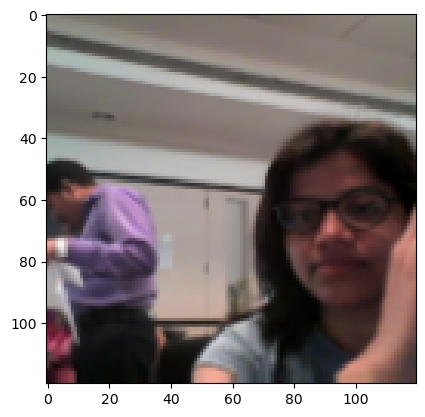

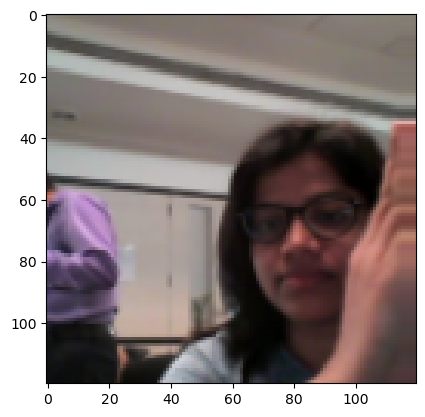

In [8]:
from keras.preprocessing.image import ImageDataGenerator
#from keras.preprocessing.image import smart_resize

datagen = ImageDataGenerator(
    zoom_range=0.1,
    zca_whitening=True,
    width_shift_range=0.1,
    height_shift_range=0.1)

## Test code start
#360 by 360
image1 = imageio.imread(r"Project_data\train\WIN_20180907_15_35_09_Pro_Right Swipe_new\WIN_20180907_15_35_09_Pro_00012.png")
#160 by 120
image2 = imageio.imread(r"Project_data\train\WIN_20180907_15_35_09_Pro_Right Swipe_new\WIN_20180907_15_35_09_Pro_00014.png")
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes                    
#print(image1.shape, image2.shape)
image1 = resize(image1, (120, 120), anti_aliasing=True)
image1 = datagen.random_transform(image1)                   
plt.imshow(image1)
plt.show()
image2 = resize(image2, (120, 120), anti_aliasing=True)
image2 = datagen.random_transform(image2)                 
plt.imshow(image2)
plt.show()
## Test code end

def generate(source_path, folder_list, batch_size, num_images=20, height=120, width=120, augment=False):
    #print( 'Source path = ', source_path, '; batch size =', batch_size)
    total_frames = 30

    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size # calculate the number of batches
        #img_idx = sorted(rn.sample(range(0, total_frames), num_images)) #create a list of image numbers you want to use for a particular video
        img_idx = np.round(np.linspace(0,total_frames-1,num_images)).astype(int) #create a list of image numbers you want to use for a particular video

        for batch in range(num_batches): # we iterate over the number of batches
            batch_data   = np.zeros((batch_size, num_images, height, width, 3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size, 5)) # batch_labels is the one hot representation of the output           

            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes                    
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)

                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image                  
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        # write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_batch_size = len(t)%batch_size
            batch_data   = np.zeros((remaining_batch_size, num_images, height, width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_batch_size,5)) # batch_labels is the one hot representation of the output           

            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    h, w, c = image.shape
                    image = resize(image, (height, width), anti_aliasing=True)                          
                    
                    # Randomly transform few images of few folders; note that folders are randomly shuffled in each epoch too
                    if augment:
                        if np.random.randn() > 0:
                            image = datagen.random_transform(image)                   

                    batch_data[folder,idx,:,:,0] = (image[...,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[...,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[...,2])/255 #normalise and feed in the image
                   
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here we make the model using different functionalities that Keras provides. We will use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. We would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. We will Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [9]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, GRU, LSTM, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras import optimizers

### Conv3d Models

In [10]:
# Common utility to create conv 3D models
def conv3D(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (3, 3, 3), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

#### Model 1: Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)


In [24]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 30
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_7 (Activation)   (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 30, 120, 120, 16)  64       
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                            

 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 activation_12 (Activation)  (None, 128)               0         
                                                                 
 batch_normalization_11 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                 645       
                                                                 
 activatio

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [25]:
callbacks_list = model_callbacks("model_conv3D_1")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [26]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                             callbacks=callbacks_list, validation_data=val_generator, 
                             validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_13976\109625498.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
65/67 [============================>.] - ETA: 5s - loss: 1.5346 - categorical_accuracy: 0.4292

C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_13976\109625498.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.5334 - categorical_accuracy: 0.4299
Epoch 1: val_loss improved from inf to 3.02183, saving model to model_conv3D_1_2024-03-0313_31_46.421778\model-00001-1.53340-0.42986-3.02183-0.18000.h5
67/67 [==============================] - 200s 3s/step - loss: 1.5334 - categorical_accuracy: 0.4299 - val_loss: 3.0218 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.0735 - categorical_accuracy: 0.6063
Epoch 2: val_loss did not improve from 3.02183
67/67 [==============================] - 183s 3s/step - loss: 1.0735 - categorical_accuracy: 0.6063 - val_loss: 3.3467 - val_categorical_accuracy: 0.2400 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.9038 - categorical_accuracy: 0.6878
Epoch 3: val_loss did not improve from 3.02183
67/67 [==============================] - 183s 3s/step - loss: 0.9038 - categorical_accuracy: 0.6878 - val_loss: 3

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


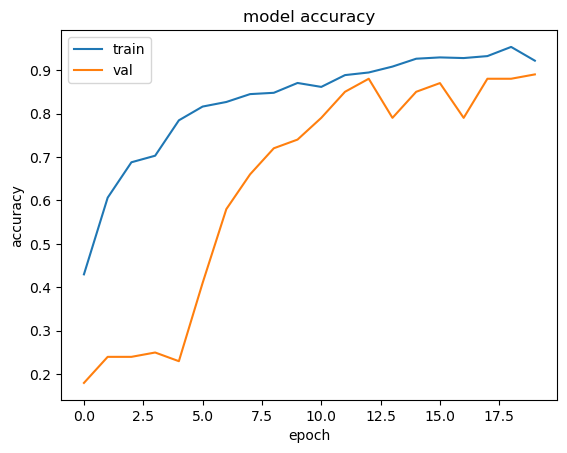

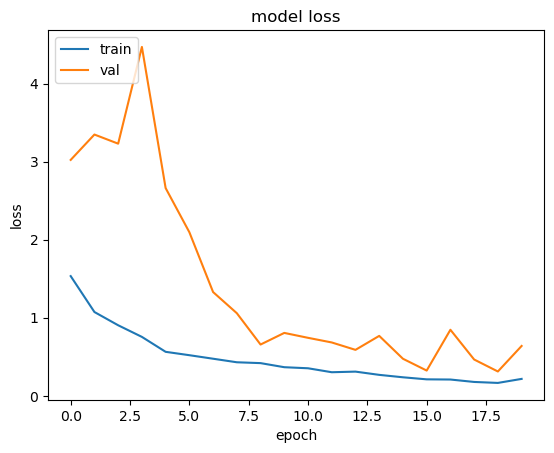

In [27]:
plot_loss_accuracy(history)

#### Model 2: Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [28]:
num_epochs = 20 # choose the number of epochs
#print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# batch size = 10
# num_frames per video = 20
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 20, 120, 120, 16)  1312      
                                                                 
 activation_14 (Activation)  (None, 20, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 20, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 10, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 10, 60, 60, 32)    13856     
                                                                 
 activat

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [29]:
callbacks_list = model_callbacks("model_conv3D_2")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [30]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_13976\109625498.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
65/67 [============================>.] - ETA: 3s - loss: 1.5333 - categorical_accuracy: 0.4538

C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_13976\109625498.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.5296 - categorical_accuracy: 0.4570
Epoch 1: val_loss improved from inf to 2.59461, saving model to model_conv3D_2_2024-03-0313_31_46.421778\model-00001-1.52959-0.45701-2.59461-0.19000.h5
67/67 [==============================] - 137s 2s/step - loss: 1.5296 - categorical_accuracy: 0.4570 - val_loss: 2.5946 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 1.0182 - categorical_accuracy: 0.6154
Epoch 2: val_loss did not improve from 2.59461
67/67 [==============================] - 120s 2s/step - loss: 1.0182 - categorical_accuracy: 0.6154 - val_loss: 2.9778 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.7468 - categorical_accuracy: 0.7179
Epoch 3: val_loss did not improve from 2.59461
67/67 [==============================] - 120s 2s/step - loss: 0.7468 - categorical_accuracy: 0.7179 - val_loss: 4

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


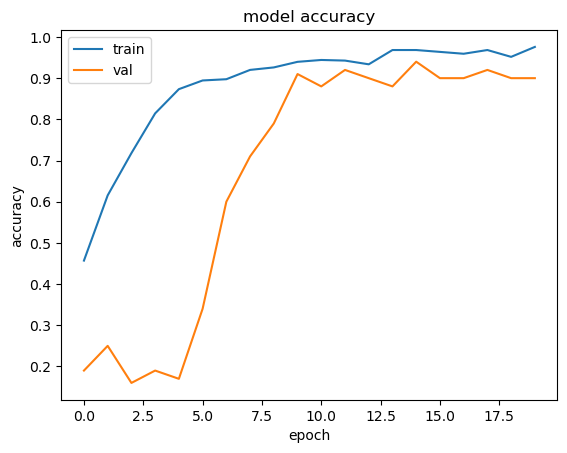

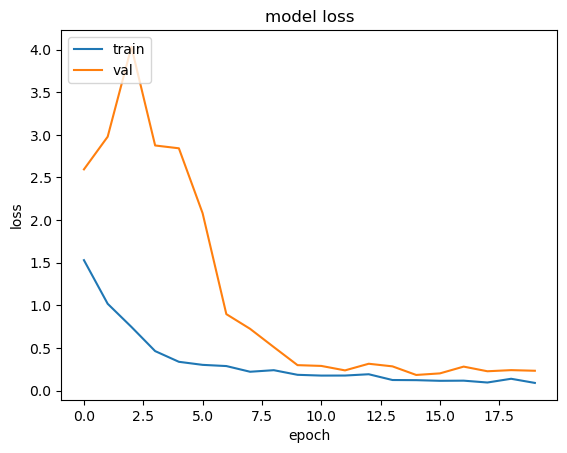

In [31]:
plot_loss_accuracy(history)

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

#### Model 3: Conv 3D Model with 20 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 160 by 160)

In [32]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 160
width = 160

model = conv3D(num_images=num_frames, height=160, width=160)

print (model.summary())

# epochs = 20
# batch size = 10
# num_frames per video = 20
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 20, 160, 160, 16)  1312      
                                                                 
 activation_21 (Activation)  (None, 20, 160, 160, 16)  0         
                                                                 
 batch_normalization_18 (Bat  (None, 20, 160, 160, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 10, 80, 80, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 10, 80, 80, 32)    13856     
                                                            

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [33]:
callbacks_list = model_callbacks("model_conv3D_3")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames, height=160, width=160)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames, height=160, width=160)

In [34]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_13976\109625498.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
65/67 [============================>.] - ETA: 3s - loss: 1.4499 - categorical_accuracy: 0.4831

C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_13976\109625498.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.4524 - categorical_accuracy: 0.4811
Epoch 1: val_loss improved from inf to 4.90941, saving model to model_conv3D_3_2024-03-0313_31_46.421778\model-00001-1.45241-0.48115-4.90941-0.25000.h5
67/67 [==============================] - 154s 2s/step - loss: 1.4524 - categorical_accuracy: 0.4811 - val_loss: 4.9094 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/20
67/67 [==============================] - ETA: 0s - loss: 0.9154 - categorical_accuracy: 0.6772
Epoch 2: val_loss improved from 4.90941 to 4.51945, saving model to model_conv3D_3_2024-03-0313_31_46.421778\model-00002-0.91537-0.67722-4.51945-0.26000.h5
67/67 [==============================] - 152s 2s/step - loss: 0.9154 - categorical_accuracy: 0.6772 - val_loss: 4.5194 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/20
67/67 [==============================] - ETA: 0s - loss: 0.7090 - categorical_accuracy: 0.7466
Epoch 3: val_loss improved from 4.51945 to 4.17015,

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


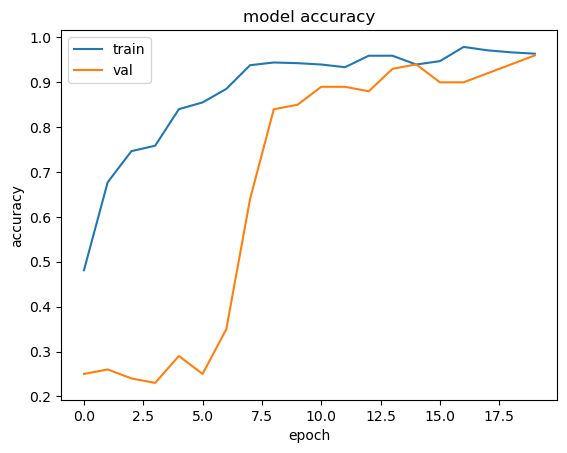

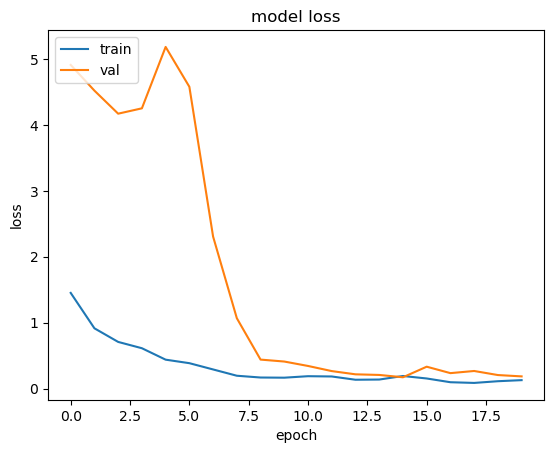

In [35]:
plot_loss_accuracy(history)

#### Conv 3D Model with 30 frames per video (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer) + Random data transformations on training data set

In [36]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D(num_images=num_frames)

print (model.summary())

# epochs = 15
# batch size = 10
# num_frames per video = 30
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_16 (Conv3D)          (None, 30, 120, 120, 16)  1312      
                                                                 
 activation_28 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_24 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 15, 60, 60, 16)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 15, 60, 60, 32)    13856     
                                                            

In [37]:
callbacks_list = model_callbacks("model_conv3D_4")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [38]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_13976\109625498.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/15
65/67 [============================>.] - ETA: 5s - loss: 1.6765 - categorical_accuracy: 0.4185

C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_13976\109625498.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.6732 - categorical_accuracy: 0.4178
Epoch 1: val_loss improved from inf to 3.68637, saving model to model_conv3D_4_2024-03-0313_31_46.421778\model-00001-1.67323-0.41780-3.68637-0.21000.h5
67/67 [==============================] - 202s 3s/step - loss: 1.6732 - categorical_accuracy: 0.4178 - val_loss: 3.6864 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/15
67/67 [==============================] - ETA: 0s - loss: 1.2226 - categorical_accuracy: 0.5339
Epoch 2: val_loss did not improve from 3.68637
67/67 [==============================] - 208s 3s/step - loss: 1.2226 - categorical_accuracy: 0.5339 - val_loss: 10.6357 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 3/15
67/67 [==============================] - ETA: 0s - loss: 1.2563 - categorical_accuracy: 0.5279
Epoch 3: val_loss did not improve from 3.68637
67/67 [==============================] - 204s 3s/step - loss: 1.2563 - categorical_accuracy: 0.5279 - val_loss: 

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


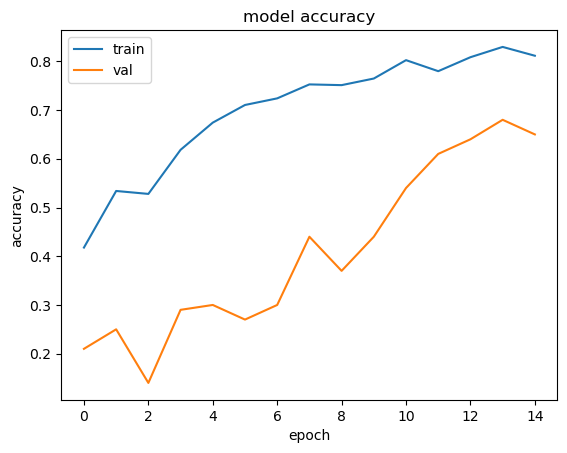

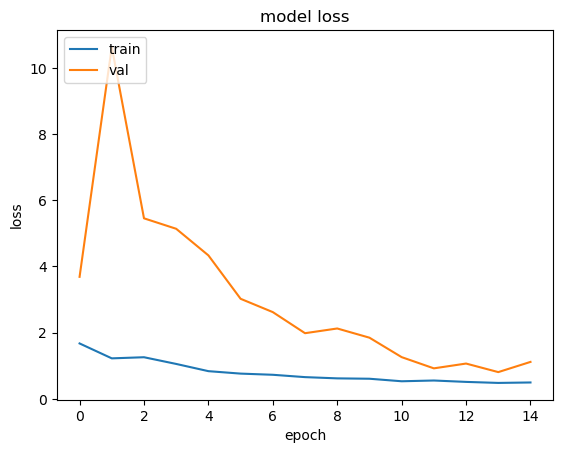

In [39]:
plot_loss_accuracy(history)

#### Model 5: Conv 3D Model with 30 frames per video (8, 16, 32, 64 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [40]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

conv_filters = (8, 16, 32, 64) 
model = conv3D(conv_filters, num_images=num_frames)
print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 30
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 30, 120, 120, 8)   656       
                                                                 
 activation_35 (Activation)  (None, 30, 120, 120, 8)   0         
                                                                 
 batch_normalization_30 (Bat  (None, 30, 120, 120, 8)  32        
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 15, 60, 60, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 15, 60, 60, 16)    3472      
                                                            

In [41]:
callbacks_list = model_callbacks("model_conv3D_5")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [42]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_13976\109625498.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/25
65/67 [============================>.] - ETA: 4s - loss: 1.5168 - categorical_accuracy: 0.4754

C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_13976\109625498.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.5141 - categorical_accuracy: 0.4781
Epoch 1: val_loss improved from inf to 6.86471, saving model to model_conv3D_5_2024-03-0313_31_46.421778\model-00001-1.51405-0.47813-6.86471-0.16000.h5
67/67 [==============================] - 182s 3s/step - loss: 1.5141 - categorical_accuracy: 0.4781 - val_loss: 6.8647 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.0125 - categorical_accuracy: 0.6320
Epoch 2: val_loss did not improve from 6.86471
67/67 [==============================] - 180s 3s/step - loss: 1.0125 - categorical_accuracy: 0.6320 - val_loss: 10.4701 - val_categorical_accuracy: 0.1600 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 0.7844 - categorical_accuracy: 0.6878
Epoch 3: val_loss improved from 6.86471 to 4.14521, saving model to model_conv3D_5_2024-03-0313_31_46.421778\model-00003-0.78437-0.68778-4.14521-0.16000.h5
67/

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


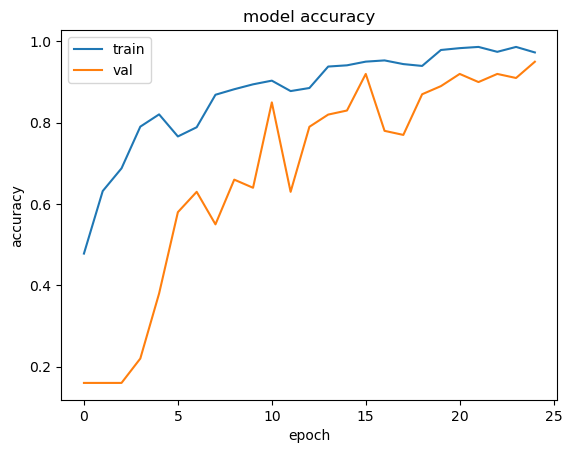

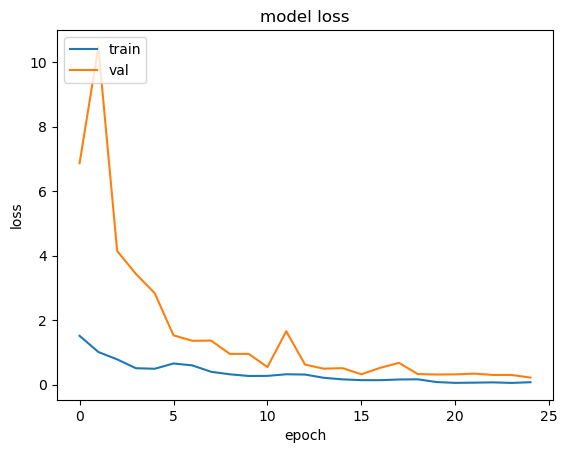

In [43]:
plot_loss_accuracy(history)

#### Model 6: Conv 3D Model with 20 frames per video (32, 64, 128, 256) filters conv 3D layers + 128 dense layer + 128 dense layer + image size 120 by 120)

In [14]:
num_epochs = 25 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 10  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num_frames per video =', num_frames)
height = 120
width = 120

conv_filters = (32, 64, 128, 256)
dense_filters = (128, 128)
model = conv3D(conv_filters=conv_filters,dense_nodes=dense_filters, num_images=num_frames)
print (model.summary())

# epochs = 25
# batch size = 10
# num_frames per video = 20
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 20, 120, 120, 32)  2624      
                                                                 
 activation_7 (Activation)   (None, 20, 120, 120, 32)  0         
                                                                 
 batch_normalization_6 (Batc  (None, 20, 120, 120, 32)  128      
 hNormalization)                                                 
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 10, 60, 60, 32)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 10, 60, 60, 64)    55360     
                                                            

In [15]:
callbacks_list = model_callbacks("model_conv3D_6")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=False, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [16]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_17868\109625498.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/25
65/67 [============================>.] - ETA: 3s - loss: 1.6842 - categorical_accuracy: 0.4000

C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_17868\109625498.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


67/67 [==============================] - ETA: 0s - loss: 1.6781 - categorical_accuracy: 0.3982
Epoch 1: val_loss improved from inf to 2.69350, saving model to model_conv3D_6_2024-03-0318_39_44.194910\model-00001-1.67806-0.39819-2.69350-0.14000.h5
67/67 [==============================] - 136s 2s/step - loss: 1.6781 - categorical_accuracy: 0.3982 - val_loss: 2.6935 - val_categorical_accuracy: 0.1400 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 1.2035 - categorical_accuracy: 0.5264
Epoch 2: val_loss did not improve from 2.69350
67/67 [==============================] - 124s 2s/step - loss: 1.2035 - categorical_accuracy: 0.5264 - val_loss: 3.6707 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 0.9203 - categorical_accuracy: 0.6606
Epoch 3: val_loss did not improve from 2.69350
67/67 [==============================] - 123s 2s/step - loss: 0.9203 - categorical_accuracy: 0.6606 - val_loss: 3

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


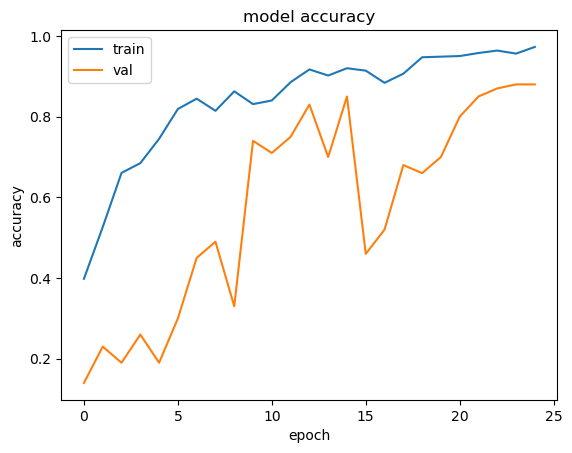

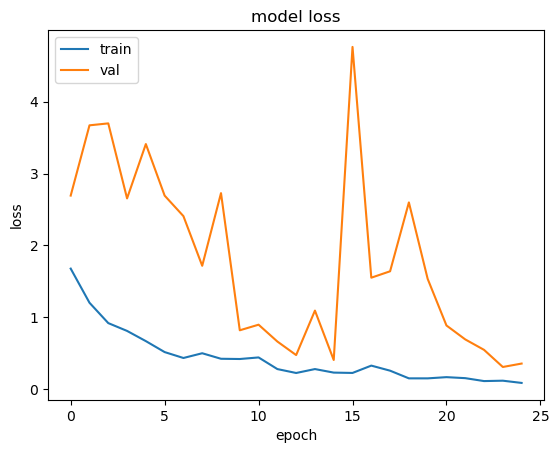

In [17]:
plot_loss_accuracy(history)

#### Model 7: Conv 3D Model with 30 frames per video and a 5 by 5 filter size (16, 32, 64, 128 filters conv 3D layers + 256 dense layer + 128 dense layer + image size 120 by 120)

In [18]:
#write your model here
def conv3D_5by5(conv_filters=(16, 32, 64, 128), dense_nodes=(256,128), dropout=0.25, num_images=20, height=120, width=120):

    model = Sequential()

    model.add(Conv3D(conv_filters[0], (5, 5, 5), padding='same', input_shape=(num_images, height, width, 3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(conv_filters[1], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[2], (3, 3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Conv3D(conv_filters[3], (3, 3, 3), padding='same'))    
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
    model.add(Flatten())
    model.add(Dense(dense_nodes[0]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(dense_nodes[1]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))

    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    
    return model

In [19]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 5  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num_frames per video =', num_frames)
height = 120
width = 120

model = conv3D_5by5(num_images=num_frames)

print (model.summary())

# epochs = 15
# batch size = 5
# num_frames per video = 30
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_8 (Conv3D)           (None, 30, 120, 120, 16)  6016      
                                                                 
 activation_14 (Activation)  (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_12 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 15, 60, 60, 16)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 15, 60, 60, 32)    13856     
                                                             

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [20]:
callbacks_list = model_callbacks("model_conv3D_9")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [21]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_17868\109625498.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/15
131/133 [============================>.] - ETA: 2s - loss: 1.8922 - categorical_accuracy: 0.3527

C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_17868\109625498.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


133/133 [==============================] - ETA: 0s - loss: 1.8955 - categorical_accuracy: 0.3499
Epoch 1: val_loss improved from inf to 2.32850, saving model to model_conv3D_9_2024-03-0318_39_44.194910\model-00001-1.89550-0.34992-2.32850-0.30000.h5
133/133 [==============================] - 193s 1s/step - loss: 1.8955 - categorical_accuracy: 0.3499 - val_loss: 2.3285 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/15
133/133 [==============================] - ETA: 0s - loss: 1.4575 - categorical_accuracy: 0.4721
Epoch 2: val_loss improved from 2.32850 to 2.00000, saving model to model_conv3D_9_2024-03-0318_39_44.194910\model-00002-1.45749-0.47210-2.00000-0.32000.h5
133/133 [==============================] - 182s 1s/step - loss: 1.4575 - categorical_accuracy: 0.4721 - val_loss: 2.0000 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 3/15
133/133 [==============================] - ETA: 0s - loss: 1.3275 - categorical_accuracy: 0.4827
Epoch 3: val_loss did not improve from 2.

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


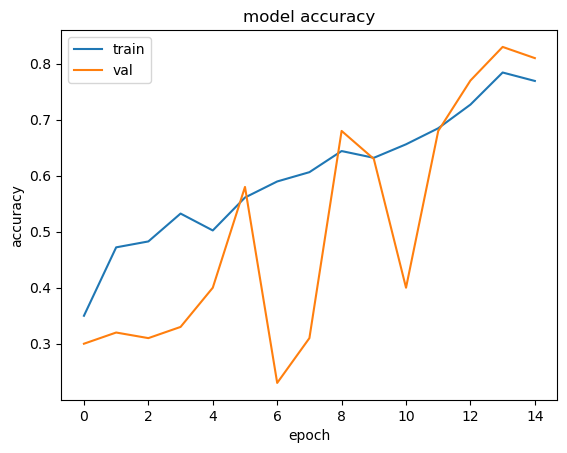

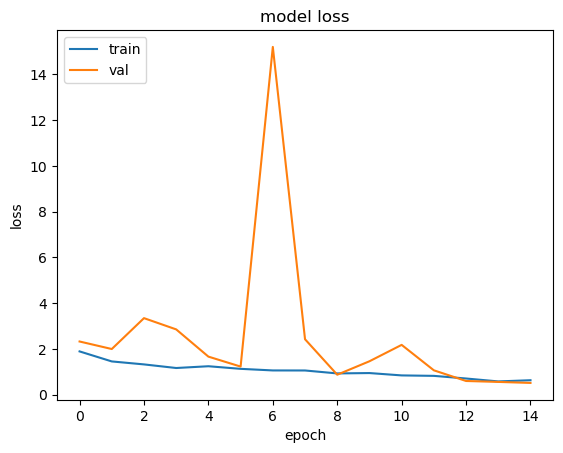

In [22]:
plot_loss_accuracy(history)

### TRANSFER LEARNING - MobileNet Conv2d + GRU

In [23]:
from keras.applications import mobilenet

def mobilenet_RNN(fine_tune=False, gru=False, lstm_gru_cells=128, dense_nodes=128, dropout=0.25, num_images=20, height=120, width=120):

    mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)
    print("Number of layers in the pretrained mobilenet model: ", len(mobilenet_transfer.layers))

    if (fine_tune):
        # Fine-tune from this layer onwards
        fine_tune_at = 50
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in mobilenet_transfer.layers[:fine_tune_at]:
            layer.trainable = False

    model = Sequential()
    model.add(TimeDistributed(mobilenet_transfer,input_shape=(num_images, height, width, 3)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
    if (gru):
        model.add(GRU(lstm_gru_cells))
    else:
        model.add(LSTM(lstm_gru_cells))
    model.add(Dropout(dropout))
    model.add(Dense(dense_nodes, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))

    opt = tf.keras.optimizers.Adam() #write your optimizer
    model.compile(opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])    
    return model

#### Model 8: Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes

In [27]:
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 5  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(num_images=num_frames, gru=True)
print (model.summary())

# epochs = 20
# batch size = 5
# num frames per video = 20
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 20, 3, 3, 1024)   3228864   
 tributed)                                                       
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 1024)         0         
 tributed)                                                       
     

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.
Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [28]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [29]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_17868\109625498.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/20
131/133 [============================>.] - ETA: 1s - loss: 0.9598 - categorical_accuracy: 0.6550

C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_17868\109625498.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


133/133 [==============================] - ETA: 0s - loss: 0.9510 - categorical_accuracy: 0.6591
Epoch 1: val_loss improved from inf to 0.41315, saving model to model_retrain_mobilenet_gru_2024-03-0318_39_44.194910\model-00001-0.95102-0.65913-0.41315-0.88000.h5
133/133 [==============================] - 128s 924ms/step - loss: 0.9510 - categorical_accuracy: 0.6591 - val_loss: 0.4132 - val_categorical_accuracy: 0.8800 - lr: 0.0010
Epoch 2/20
133/133 [==============================] - ETA: 0s - loss: 0.4175 - categorical_accuracy: 0.8643
Epoch 2: val_loss did not improve from 0.41315
133/133 [==============================] - 123s 925ms/step - loss: 0.4175 - categorical_accuracy: 0.8643 - val_loss: 0.4161 - val_categorical_accuracy: 0.8600 - lr: 0.0010
Epoch 3/20
133/133 [==============================] - ETA: 0s - loss: 0.3012 - categorical_accuracy: 0.9095
Epoch 3: val_loss did not improve from 0.41315
133/133 [==============================] - 123s 929ms/step - loss: 0.3012 - categori

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


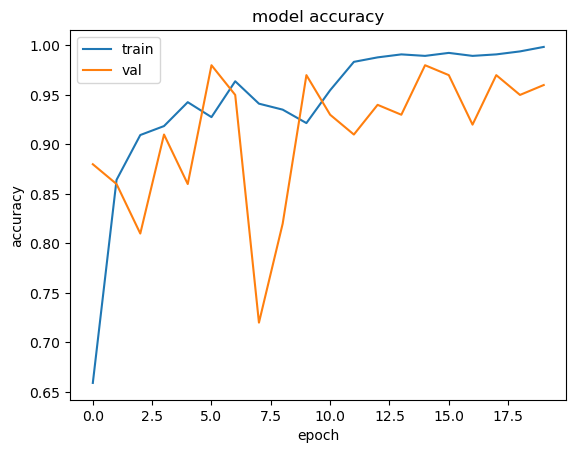

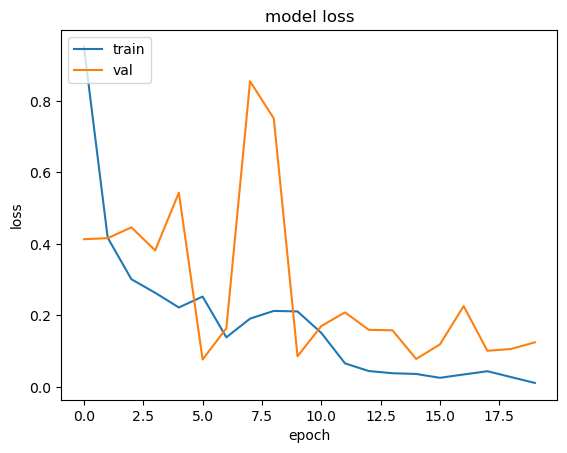

In [30]:
plot_loss_accuracy(history)

#### Model 9: Mobilenet (re train all weights) + GRU (128 cells) + 128 dense nodes + Random data transformations on training data set

In [34]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 5  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 30
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(gru=True, num_images=num_frames)
print(model.summary())

# epochs = 15
# batch size = 5
# num frames per video = 30
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 30, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_13 (TimeDi  (None, 30, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 30, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 30, 1024)         0         
 stributed)                                                      
     

In [35]:
callbacks_list = model_callbacks("model_retrain_mobilenet_gru")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, augment=True, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [36]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_17868\109625498.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/15
131/133 [============================>.] - ETA: 2s - loss: 0.8773 - categorical_accuracy: 0.6916

C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_17868\109625498.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


133/133 [==============================] - ETA: 0s - loss: 0.8682 - categorical_accuracy: 0.6953
Epoch 1: val_loss improved from inf to 0.26557, saving model to model_retrain_mobilenet_gru_2024-03-0318_39_44.194910\model-00001-0.86819-0.69532-0.26557-0.93000.h5
133/133 [==============================] - 223s 2s/step - loss: 0.8682 - categorical_accuracy: 0.6953 - val_loss: 0.2656 - val_categorical_accuracy: 0.9300 - lr: 0.0010
Epoch 2/15
133/133 [==============================] - ETA: 0s - loss: 0.4432 - categorical_accuracy: 0.8718
Epoch 2: val_loss did not improve from 0.26557
133/133 [==============================] - 214s 2s/step - loss: 0.4432 - categorical_accuracy: 0.8718 - val_loss: 0.5271 - val_categorical_accuracy: 0.8500 - lr: 0.0010
Epoch 3/15
133/133 [==============================] - ETA: 0s - loss: 0.3998 - categorical_accuracy: 0.8688
Epoch 3: val_loss did not improve from 0.26557
133/133 [==============================] - 214s 2s/step - loss: 0.3998 - categorical_accur

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


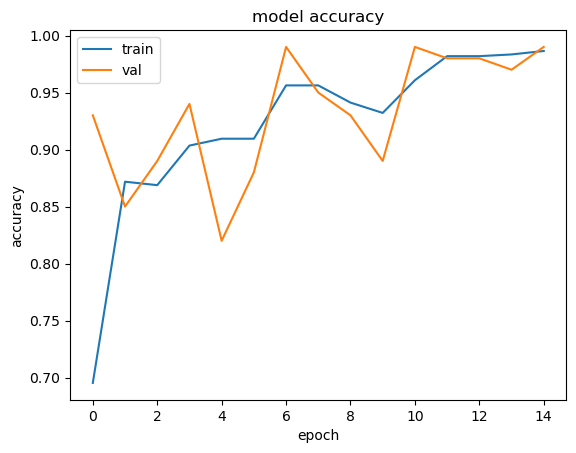

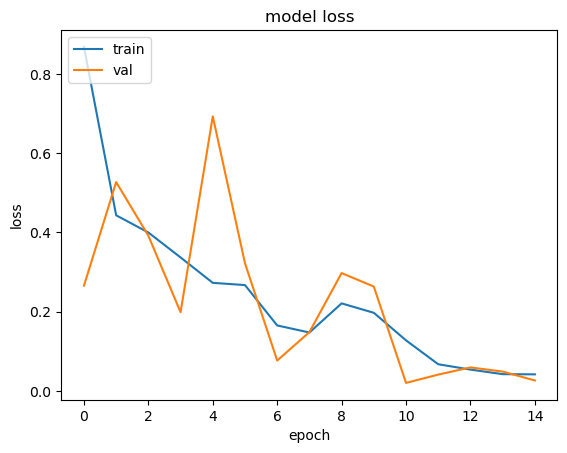

In [37]:
plot_loss_accuracy(history)

#### Model 10: Mobilenet (re train all wieghts) + LSTM (128 cells) + 128 dense nodes




In [41]:
num_epochs = 15 # choose the number of epochs
print ('# epochs =', num_epochs)
batch_size = 5  #experiment with the batch size
print ('# batch size =', batch_size)
num_frames = 20
print ('# num frames per video =', num_frames)
height = 120
width = 120

model = mobilenet_RNN(fine_tune=False, gru=False, num_images=num_frames)
print(model.summary())

# epochs = 15
# batch size = 5
# num frames per video = 20
Number of layers in the pretrained mobilenet model:  86
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_23 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
     

In [42]:
callbacks_list = model_callbacks("model_retrain_mobilenet_lstm")

steps_per_epoch, validation_steps = calculate_steps(num_train_sequences, num_val_sequences, batch_size)

train_generator = generate(train_path, train_doc, batch_size, num_images=num_frames)

val_generator   = generate(val_path, val_doc, batch_size, num_images=num_frames)

In [43]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_17868\109625498.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Epoch 1/15
131/133 [============================>.] - ETA: 1s - loss: 1.0334 - categorical_accuracy: 0.6351

C:\Users\PRATIK SINHA\AppData\Local\Temp\ipykernel_17868\109625498.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


133/133 [==============================] - ETA: 0s - loss: 1.0285 - categorical_accuracy: 0.6380
Epoch 1: val_loss improved from inf to 0.96380, saving model to model_retrain_mobilenet_lstm_2024-03-0318_39_44.194910\model-00001-1.02847-0.63801-0.96380-0.61000.h5
133/133 [==============================] - 129s 942ms/step - loss: 1.0285 - categorical_accuracy: 0.6380 - val_loss: 0.9638 - val_categorical_accuracy: 0.6100 - lr: 0.0010
Epoch 2/15
133/133 [==============================] - ETA: 0s - loss: 0.5896 - categorical_accuracy: 0.8265
Epoch 2: val_loss improved from 0.96380 to 0.89274, saving model to model_retrain_mobilenet_lstm_2024-03-0318_39_44.194910\model-00002-0.58958-0.82655-0.89274-0.71000.h5
133/133 [==============================] - 125s 945ms/step - loss: 0.5896 - categorical_accuracy: 0.8265 - val_loss: 0.8927 - val_categorical_accuracy: 0.7100 - lr: 0.0010
Epoch 3/15
133/133 [==============================] - ETA: 0s - loss: 0.4712 - categorical_accuracy: 0.8612
Epoch 3

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])


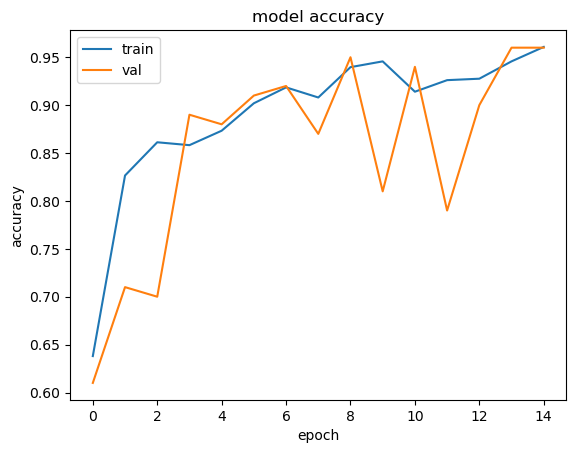

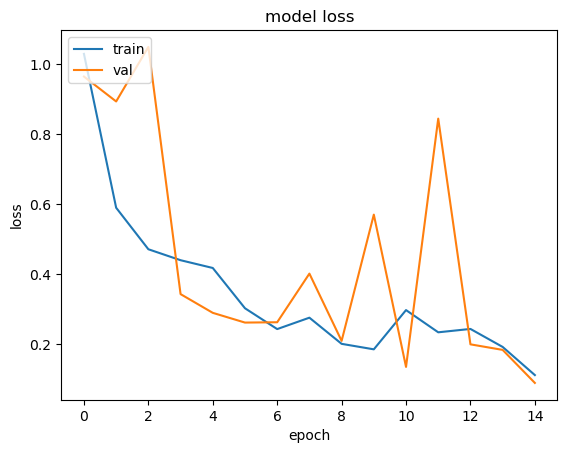

In [44]:
plot_loss_accuracy(history)